In [1]:
import os

In [2]:
data_dir = '../jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np

In [4]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

In [6]:
from matplotlib import pyplot as plt

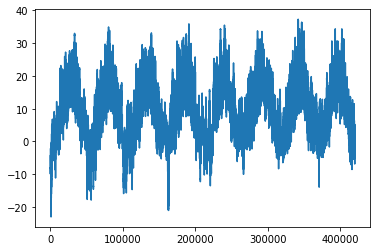

In [9]:
temp = float_data[:,1] #<1> temerature in celsius
plt.plot(range(len(temp)), temp)
plt.show()

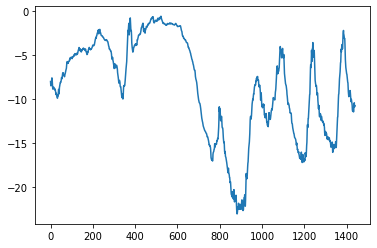

In [10]:
plt.plot(range(1440), temp[:1440])
plt.show()

```
1day * 24hrs * 60min = 1440 minutes each day we have
but the data is sampled with 10 minute interval - for a day 1440/10 = 144 samples
If we consider data for 10 days - 144*10 = 1440 points

Problem 
Taking input as the data for 5 days, predict the data for next 1 day as output

lookback = 5 days * 144 = 720 points input
delay = 1 day * 144 = 144 points output
steps = 6 - Observation will be sampled as one data point per hour 
(then we need less data point as 1 day has 24 hour - 5 days (5*24) 
and prediction will be again 24 points only

```

In [12]:
"""
Using 200k timestep data only for training
"""
mean = float_data[:200000].mean(axis=0) 
std = float_data[:200000].std(axis=0)

float_data -= mean
float_data /= std

mean,std

(array([ 988.88635885,    9.07734895,  283.14631345,    4.44854725,
          75.35405895,   13.3829553 ,    9.29695535,    4.08591725,
           5.8752111 ,    9.40521005, 1217.51429655,    2.1510037 ,
           3.56950915,  176.21703355]),
 array([ 8.48043388,  8.85249908,  8.95324185,  7.16584991, 16.72731652,
         7.68914559,  4.19808168,  4.84034436,  2.66564926,  4.25206364,
        42.48884277,  1.53666449,  2.33067298, 86.61322998]))

In [13]:
mean2 = float_data[:200000].mean(axis=0) 
std2 = float_data[:200000].std(axis=0)
mean2,std2

(array([ 2.35142852e-12, -6.28273600e-15,  7.46772859e-13, -1.21087956e-14,
         2.42951509e-14,  4.34444314e-15, -6.97213176e-15, -1.16579003e-14,
         2.78895790e-14,  7.98244804e-16, -1.30972425e-13,  1.37250925e-14,
        -5.88101390e-14, -2.93813751e-15]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [16]:
def generator(data, lookback, delay, min_ix, max_ix, shuffle=False, batch_size=128, step=6):
    
    if max_ix is None:
        max_ix = len(data)-delay-1
    
    i = min_ix + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_ix+lookback, max_ix, size=batch_size)
        else:
            if i+batch_size >= max_ix:
                i = min_ix + lookback
            
            rows = np.arange(i, min(i+batch_size, max_ix))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                           lookback//step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j,row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j],step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [30]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_ix=0,
                      max_ix=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_ix=200001,
                      max_ix=300000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_ix=300001,
                      max_ix=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000-200001-lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [31]:
val_steps,test_steps

(98559, 119010)

In [32]:
from tqdm import tqdm 

def evaluate_naive_method():
    batch_maes = []
    for step in tqdm(range(1000)):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [33]:
evaluate_naive_method()

100%|██████████| 1000/1000 [00:04<00:00, 205.54it/s]

0.2891756689244951


In [35]:
std[1]

8.85249908220462

In [34]:
0.29*std[1]

2.5672247338393395

In [38]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=100, epochs=10, validation_data=val_gen, validation_steps=100)

Epoch 1/10
100/100 [==============================] - 2s 14ms/step - loss: 3.7879 - val_loss: 2.8073
Epoch 2/10
100/100 [==============================] - 1s 13ms/step - loss: 2.2080 - val_loss: 2.0599
Epoch 3/10
100/100 [==============================] - 1s 13ms/step - loss: 1.7989 - val_loss: 1.3473
Epoch 4/10
100/100 [==============================] - 1s 13ms/step - loss: 1.4468 - val_loss: 1.2352
Epoch 5/10
100/100 [==============================] - 1s 13ms/step - loss: 1.2036 - val_loss: 0.8561
Epoch 6/10
100/100 [==============================] - 1s 13ms/step - loss: 0.9661 - val_loss: 0.8529
Epoch 7/10
100/100 [==============================] - 1s 13ms/step - loss: 0.8149 - val_loss: 0.6061
Epoch 8/10
100/100 [==============================] - 1s 13ms/step - loss: 0.6725 - val_loss: 0.5648
Epoch 9/10
100/100 [==============================] - 1s 13ms/step - loss: 0.5577 - val_loss: 0.4334
Epoch 10/10
100/100 [==============================] - 1s 13ms/step - loss: 0.4695 - val_lo

In [43]:
history = model.fit(train_gen, steps_per_epoch=100, epochs=10, validation_data=val_gen, validation_steps=100)

Epoch 1/10
100/100 [==============================] - 1s 13ms/step - loss: 0.4026 - val_loss: 0.3421
Epoch 2/10
100/100 [==============================] - 1s 13ms/step - loss: 0.3624 - val_loss: 0.3891
Epoch 3/10
100/100 [==============================] - 1s 13ms/step - loss: 0.3405 - val_loss: 0.3293
Epoch 4/10
100/100 [==============================] - 1s 13ms/step - loss: 0.3229 - val_loss: 0.2949
Epoch 5/10
100/100 [==============================] - 1s 13ms/step - loss: 0.3067 - val_loss: 0.3257
Epoch 6/10
100/100 [==============================] - 1s 13ms/step - loss: 0.2957 - val_loss: 0.3640
Epoch 7/10
100/100 [==============================] - 1s 14ms/step - loss: 0.2853 - val_loss: 0.3031
Epoch 8/10
100/100 [==============================] - 1s 13ms/step - loss: 0.2837 - val_loss: 0.3001
Epoch 9/10
100/100 [==============================] - 1s 13ms/step - loss: 0.2758 - val_loss: 0.2988
Epoch 10/10
100/100 [==============================] - 1s 13ms/step - loss: 0.2716 - val_lo

In [45]:
model.save('temp_baseline.h5')

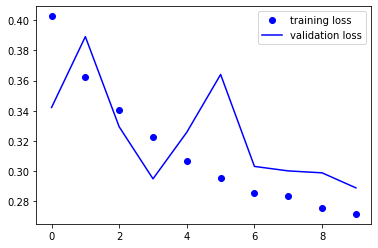

In [44]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.legend()
plt.show()


# acc = history.history["acc"]
# val_acc = history.history["val_acc"]
# plt.plot(epochs, acc, 'bo', label='training acc')
# plt.plot(epochs, val_acc, 'b', label='validation acc')
# plt.legend()
# plt.show()


In [50]:
model.evaluate(test_gen, steps=100)

100/100 [==============================] - 1s 7ms/step - loss: 0.3092


0.30919256806373596

In [52]:
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

In [53]:
with open('jena_data_float.npy','wb') as f:
    np.save(f, float_data)
        
with open('jena_data_float.npy', 'rb') as f:
    test = np.load(f)
    
print(float_data.shape)
print(test.shape)

(420451, 14)
(420451, 14)
